## Hierarchical Linear Regression in PyMC3

This hierachical modelling is especially advantageous when multi-level data is used, making the most of all information available by its 'shrinkage-effect'.

Having multiple sets of measurements comes up all the time, in Psychology for example you test multiple subjects on the same task. You then might want to estimate a model that describes the behavior as a set of parameters relating to mental functioning. Often we are interested in individual differences of these parameters but also assume that subjects share similarities (being human and all).

### The kaggle house-price data set
In this dataset the House sales price has been given among different houses in different neighborhood in the Iowa states. In the initial study, we observed that Multiple Linear Regression with L1-norm regulization already gives us fairly good prediction rate. At the same time, we observed neighborhood can be an important contributors to the overall predicting model along with other important features such as Overall Condition , Total square footage of the house..., etc.

Here I am using the same dataset to investigate if we can use Hierarchical Linear Regression to improve the SalePrice Prediction models.


In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm 

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


df_train = pd.read_csv('data/train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df_train_label = df_train[["Id", "SalePrice"]]
df_train = df_train.drop('SalePrice', axis=1)

df_train = df_train.set_index("Id")
df_train_label = df_train_label.set_index("Id")

df_test = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

test_null_columns=df_test.columns[df_test.isnull().any()] 
train_null_columns=df_train.columns[df_train.isnull().any()] 
test_null_only_ColIdx = test_null_columns.difference(train_null_columns)

test_null_only_RowIdx = [ df_test[df_test[idx].isnull()].index.tolist() for idx in test_null_only_ColIdx ]
test_null_only_RowIdx = list ( set(x for l in test_null_only_RowIdx for x in l) )

problematicTestSet = df_test.loc[ df_test.index.isin( test_null_only_RowIdx ) ]

fineTestSet = df_test.loc[ ~df_test.index.isin( test_null_only_RowIdx ) ]  #1447 records

problematicTestSet= problematicTestSet.set_index("Id")
fineTestSet = fineTestSet.set_index("Id")
df_test = df_test.set_index("Id")

df = pd.concat([df_train,df_test], axis=0, sort=True)

problematicTestSet.index

/Users/hueyling/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Int64Index([1556, 1916, 1946, 2121, 2152, 2189, 2217, 2251, 2474, 2490, 2577, 2905], dtype='int64', name='Id')

In [3]:
# Useful if you are debugging the function inside another .py script
%load_ext autoreload
%autoreload 2

### Separate regressions for each Neighborhood

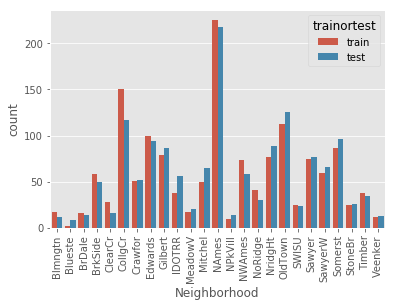

In [4]:
test =df_test.groupby("Neighborhood").size()
train = df_train.groupby("Neighborhood").size()
x = pd.DataFrame( ["train"] * len(train) )
x = x.set_index(train.index)
train = pd.concat( [ train, x ], axis = 1 )

x = pd.DataFrame( ["test"] * len(test) )
x = x.set_index(test.index)
test = pd.concat( [ test, x ], axis = 1 )

train_test = pd.concat( [ train , test ], axis = 0 )
train_test.columns = ["count" , "trainortest"]
train_test = train_test.reset_index()
sns.barplot( x="Neighborhood", y="count", hue="trainortest", data=train_test) 
plt.xticks(rotation=90)
plt.show()

Still Impute Data with preprocess.py subfunction but keep the Neighborhood intact.

In [5]:
#After write everything as a function. This is how you call the impute function
from preprocess import impute
df_label_count, encodedDic = impute( df, False, False,"Neighborhood")  # label encode categorical data
df_onehot, _ = impute( df, True, False,"Neighborhood")  # onehot encode categorical data

In [7]:
df_onehot.sample(5)

,Alley_Pave,Alley_nan,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,CentralAir_Y,CentralAir_nan,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Functional_nan,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_nan,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,Street_Pave,Street_nan,Utilities_NoSeWa,Utilities_nan,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,YrSold_nan,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtQual,EnclosedPorch,ExterCond,ExterQual,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageCond,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LotArea,LotFrontage,LowQualFinSF,MiscVal,OpenPorchSF,OverallCond,OverallQual,PoolArea,PoolQC,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,Exterior_AsbShng,Exterior_AsphShn,Exterior_BrkComm,Exterior_BrkFace,Exterior_CBlock,Exterior_CemntBd,Exterior_HdBoard,Exterior_ImStucc,Exterior_MetalSd,Exterior_Other,Exterior_Plywood,Exterior_Stone,Exterior_Stucco,Exterior_Unknown,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_WdShing,TotalFlrSF,Bsmt_ALQ,Bsmt_BLQ,Bsmt_GLQ,Bsmt_LwQ,Bsmt_Rec,Bsmt_Unf,Bsmt_Unknown,BsmtBath,TotalPorchSF,MasVnr_BrkCmn,MasVnr_BrkFace,MasVnr_None,MasVnr_Stone,MasVnr_Unknown,Cond_Artery,Cond_Feedr,Cond_Norm,Cond_PosA,Cond_PosN,Cond_RRAe,Cond_RRAn,Cond_RRNe,Cond_RRNn,Neighborhood
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
878,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,

Start some subset of the data

In [8]:
selectedCol = ['OverallCond','OverallQual','Neighborhood','TotalFlrSF','TotalBsmtSF','LotFrontage','ExterQual', 'ExterCond','BsmtCond','HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'BsmtQual', "YearBuilt", "YearRemodAdd", "CentralAir_Y"]
#selectedCol = ['Neighborhood', 'OverallQual']
df_onehot = df_onehot[selectedCol]

In [9]:
df_test = df_onehot[df_onehot.index >= min(df_test.index)]
df_train = df_onehot[df_onehot.index < min(df_test.index)]

print( df_train.shape )
print( df_test.shape )

(1460, 19)
(1459, 19)


In [10]:
df_train_label = df_train_label.astype(int)
df_train_label_log = np.log( df_train_label )

#plt.rcParams['figure.figsize'] = (5.0, 5.0)
#df_train_label.hist()
#df_train_label_log.hist()

In [11]:
data = pd.concat( [df_train, df_train_label_log], axis = 1)
neighborhoods = data["Neighborhood"].unique()

### Individual/non-hierarchical model

In [12]:
indiv_traces = {}
for neighborhood in neighborhoods:
    # Select subset of data belonging to county
    c_data = data.ix[data.Neighborhood == neighborhood]
    c_data = c_data.reset_index(drop=True)
    
    c_log_saleprice = c_data.SalePrice
    c_cond_measure = c_data.OverallQual.values
    
    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        price_est = a + b * c_cond_measure
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=price_est, sd=eps, observed=c_log_saleprice)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[neighborhood] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
The acceptance probability does not match the target. It is 0.8910586130568666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857504080654307, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
The acceptance probability does not match the target. It is 0.8793648250807365, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
The acceptance probability does not match the target. It is 0.9103988029778386, but should be close to 0.8. Try 

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.547894209050231, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6395316624665245, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


### Hierarchical Model

In [188]:
count = data['Neighborhood'].value_counts()
nei_idx_dic = dict( list( zip (count.index, range(len(count) ) ) ) ) 
data["Neighborhood_index"] = data["Neighborhood"].map(lambda x: nei_idx_dic.get(x, 0))

neighborhood_idx = data['Neighborhood_index'].values
neighborhood_idx


array([ 1, 22,  1, ..., 11,  0,  3])

In [195]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each neighborhood, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(data.Neighborhood.unique()))
    # Intercept for each neighborhood, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(data.Neighborhood.unique()))
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    price_est = a[neighborhood_idx] + b[neighborhood_idx] * data.OverallQual.values
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=price_est, sd=eps, observed=data.SalePrice)

with hierarchical_model:
    hierarchical_trace = pm.sample(njobs=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [eps, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 5 chains: 100%|██████████| 5000/5000 [03:09<00:00,  9.15draws/s]
The acceptance probability does not match the target. It is 0.9712048979269556, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9735833578226905, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5712138090915102, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9705466777190249, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the 

In [1]:
summary(hierarchical_model, varnames=['b'])

NameError: name 'summary' is not defined

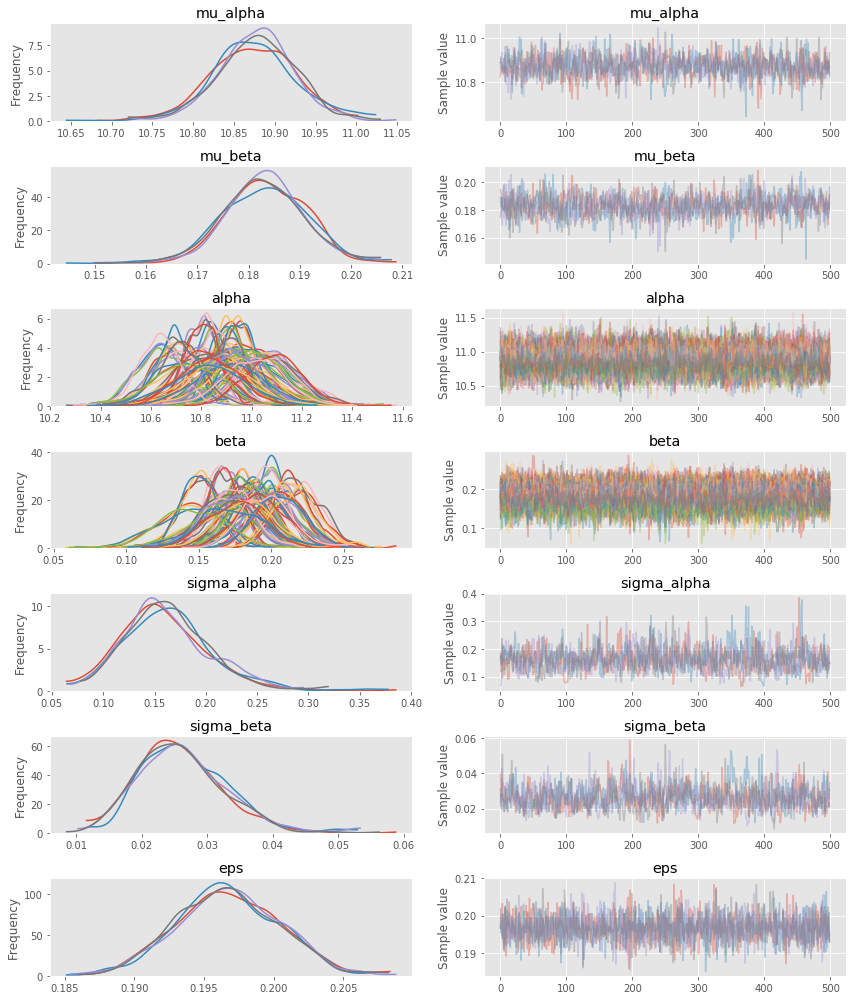

In [192]:
pm.traceplot(hierarchical_trace);

In [193]:
hierarchical_trace

<MultiTrace: 4 chains, 500 iterations, 10 variables>